# Setup

## Constante

In [14]:
UPTIME_FOLDER_PATH = "/home/clahoche/Documents/github/my_personnal_script/daily_uptime_save"


## import

In [15]:
from src.analyze.uptime_record import UptimeRecord, WeekDay

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import defaultdict
from datetime import timedelta, date


## Loading

In [16]:
unfused_uptime = UptimeRecord.parse_folder(UPTIME_FOLDER_PATH)
fused_uptime = UptimeRecord.fuse(unfused_uptime)

# plot and informations

## informations

In [17]:
def display_general_informations(unfused_records: list[UptimeRecord], fused_records: list[UptimeRecord]) -> None:
    distinct_date : set[date] = set()
    for record in unfused_records:
        distinct_date.add(record.start_time.date())
    
    print(f"Total number of distinct days : {len(distinct_date)}")


   

    ## ------------------ fused records ------------------

    hours = sum([record.duration.total_seconds() / (60 * 60) for record in fused_records])
    days = sum([record.duration.total_seconds() / (60 * 60 * 24) for record in fused_records])

    print(f"Total number of records: {len(fused_records)}")
    print(f"Total uptime: {hours:.2f} hours ({days:.2f} days)")
    print(f"Average uptime per record: {hours / len(fused_records):.2f} hours")
    print(f"From {fused_records[0].start_time.date()} to {fused_records[-1].start_time.date()}")

display_general_informations(unfused_uptime, fused_uptime)

Total number of distinct days : 257
Total number of records: 579
Total uptime: 1602.85 hours (66.79 days)
Average uptime per record: 2.77 hours
From 2024-01-10 to 2025-05-27


## plot by day

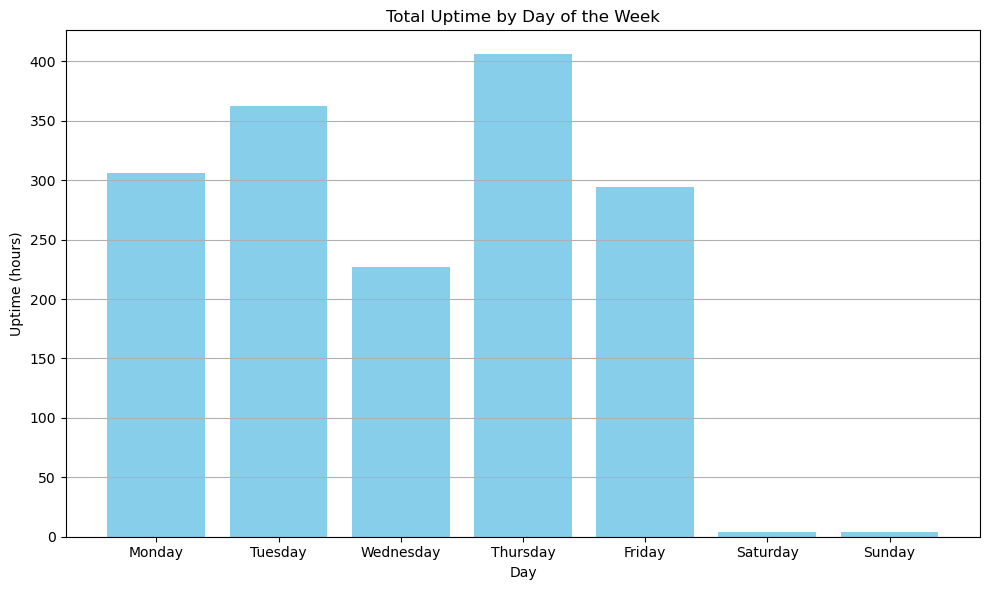

In [18]:


def plot_uptime_by_day(records: list[UptimeRecord]):
    # Fuse overlapping records
    fused_records = UptimeRecord.fuse(records)

    # Aggregate total uptime per weekday
    total_uptime :dict[WeekDay, timedelta]= defaultdict(timedelta)
    for record in fused_records:
        for weekday, duration in record.uptime_by_day():
            total_uptime[weekday] += duration

    # Sort by weekday
    sorted_days = sorted(total_uptime.items(), key=lambda x: x[0].value)
    labels = [day.name.capitalize() for day, _ in sorted_days]
    hours = [duration.total_seconds() / 3600 for _, duration in sorted_days]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(labels, hours, color='skyblue')
    plt.title("Total Uptime by Day of the Week")
    plt.xlabel("Day")
    plt.ylabel("Uptime (hours)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

plot_uptime_by_day(fused_uptime)

## heatmap

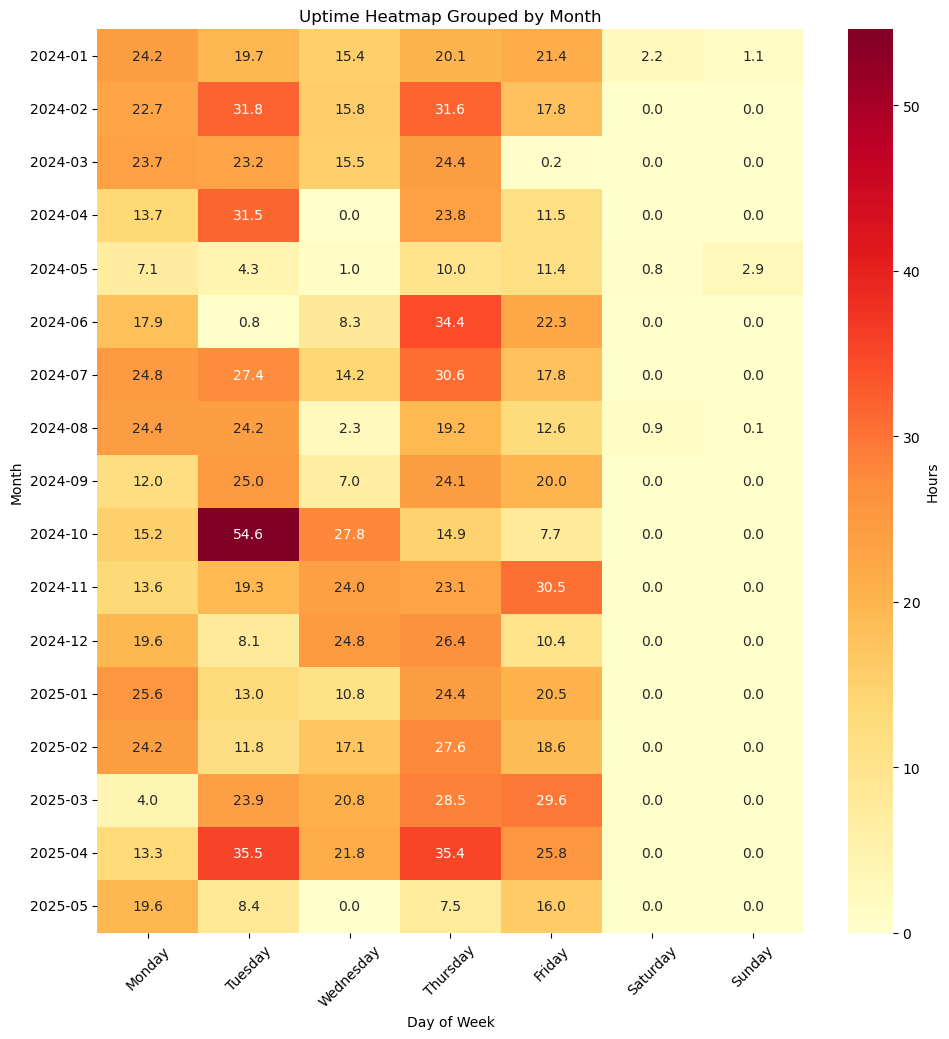

In [20]:
def plot_uptime_heatmap(records: list[UptimeRecord], group_by: str = "week"):
    assert group_by in {"week", "month", "year"}, "group_by must be 'week', 'month', or 'year'"

    # Fuse overlapping records
    fused_records = UptimeRecord.fuse(records)

    # Aggregate durations
    aggregate = defaultdict(timedelta)

    for record in fused_records:
        current_start = record.start_time
        current_end = record.end_time

        while current_start < current_end:
            next_day = (current_start + timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
            split_end = min(current_end, next_day)
            duration = split_end - current_start

            dt = current_start
            weekday = WeekDay(dt.weekday())

            if group_by == "week":
                key = (dt.isocalendar().year, dt.isocalendar().week, weekday)
            elif group_by == "month":
                key = (dt.year, dt.month, weekday)
            elif group_by == "year":
                key = (dt.year, weekday)

            aggregate[key] += duration
            current_start = split_end

    # Identify all groups
    if group_by == "week":
        group_keys = sorted(set((y, w) for y, w, _ in aggregate))
        group_labels = [f"{y}-W{w:02d}" for y, w in group_keys]
        row_builder = lambda y, w: [(y, w, day) for day in WeekDay]
    elif group_by == "month":
        group_keys = sorted(set((y, m) for y, m, _ in aggregate))
        group_labels = [f"{y}-{m:02d}" for y, m in group_keys]
        row_builder = lambda y, m: [(y, m, day) for day in WeekDay]
    elif group_by == "year":
        group_keys = sorted(set((y,) for y, _ in aggregate))
        group_labels = [f"{y}" for y, in group_keys]
        row_builder = lambda y: [(y, day) for day in WeekDay]

    # Construct heatmap matrix
    matrix = []
    for key in group_keys:
        row = []
        for composite_key in row_builder(*key):
            duration = aggregate.get(composite_key, timedelta(0))
            row.append(duration.total_seconds() / 3600.0)  # hours
        matrix.append(row)

    # Plotting
    data = np.array(matrix)
    plt.figure(figsize=(10, len(data) * 0.5 + 2))
    ax = sns.heatmap(data, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={"label": "Hours"})

    plt.xticks(np.arange(7) + 0.5, [day.name.title() for day in WeekDay], rotation=45)
    plt.yticks(np.arange(len(group_labels)) + 0.5, group_labels, rotation=0)

    plt.title(f"Uptime Heatmap Grouped by {group_by.title()}")
    plt.xlabel("Day of Week")
    plt.ylabel(group_by.title())
    plt.tight_layout()
    plt.show()

plot_uptime_heatmap(fused_uptime, group_by="month")